In [125]:
import scipy.io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy.stats import chi2
import sympy 
import seaborn as sns

%matplotlib inline

p_chi = np.array([0.05])
df_chi = np.array(list(range(1, 30)) + list(range(30, 101, 1))).reshape(-1, 1)
chi_square_table = chi2.isf(p_chi, df_chi)


# Preprocessing

In [144]:
def remove_outliers_isolation(X,Y):
    # identify outliers in the training dataset
    iso = IsolationForest(contamination=0.1)
    yhat = iso.fit_predict(X)
    # select all rows that are not outliers
    mask = yhat != -1

    X, Y = X[mask, :], Y[mask]
    return X,Y

def min_max_normalization(X,Y):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (v - v.min()) / (v.max() - v.min())
    Y=Y-1
    return X,Y

def z_normalization(X):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (v - np.mean(v)) / np.std(v)
    return X

def mahalanobis_distance(X_data):
    covariance_matrix = np.cov(X_data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    else:
        inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

    vars_mean = np.zeros(X_data.shape)
    for i in range(X_data.shape[0]):
        vars_mean[i]=X_data.mean(axis=0)
        

    diff = X_data - vars_mean
    md = []
    
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i].T)))

    return md


def MD_detect_outliers(X_data, extreme=False):
    MD = mahalanobis_distance(X_data)

    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def remove_outliers_mahalanobis(X_data,Y_data):
    outliers=MD_detect_outliers(X_data)
    x_not_outliers=np.delete(X_data,np.asarray(outliers),0)
    y_not_outliers=np.delete(Y_data,np.asarray(outliers),0)
    return x_not_outliers,y_not_outliers


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False 

# Feature Selection based on hypothesis testing.

In [3]:
# Hypothesis testing
def select_features_by_hypothesis(X,Y):
    rows,cols=X.shape
    p_values = hypothesis_testing(X,Y)
    
    number_features=np.count_nonzero(p_values != 0)
    
    new_X = np.zeros((rows,number_features))
    new_Y = np.zeros((rows,1))
    
    col_counter=0
    
    for i in range(cols):
        if p_values[i] != 0:
            col_data = X[:,i]
            new_X[:, col_counter] = col_data.A1
            col_counter+=1
            
    return new_X
    

# Return the contigency table and fredom degrees
def create_contigency_table(feature,target):
    # print(feature.shape)
    # print(target.shape)
    df = pd.DataFrame({'feature':feature[:,0], 'target':target[:,0]})

    unique_values=np.unique(np.asarray(feature))
    target_values=np.unique(np.asarray(target))

    rows=len(unique_values)+1
    cols=len(target_values)+1

    contigency_matrix= np.zeros((rows,cols))

    #Creates table
    for i in unique_values:
        value = str(i)
        for j in target_values:
            clas = str(j)
            f_temp=df.query("feature=="+value+" & target=="+clas)
            contigency_matrix[i][j]=len(f_temp)

    #Update totals
    sum_rows=contigency_matrix.sum(axis=1)
    contigency_matrix[:,cols-1]=sum_rows.T

    sum_cols=contigency_matrix.sum(axis=0)
    contigency_matrix[rows-1,:]=sum_cols

    #Calculate freedom deg
    fredom_degrees=(rows-2)*(cols-2)
    
    return contigency_matrix,fredom_degrees

def compute_chi(contigency_matrix):
    con_rows,con_cols=contigency_matrix.shape
    
    # Create table for chi tabulation
    chi_table=np.zeros(((con_rows-1)*(con_cols-1),3))

    total=contigency_matrix[con_rows-1,con_cols-1]
    
    row_counter=0

    for i in range(con_rows-1):
        row_total=contigency_matrix[i,con_cols-1]

        for j in range(con_cols-1):
            col_total = contigency_matrix[con_rows-1,j]
            p=(row_total/total)*(col_total/total)
            expected_value = total*p
            observed_value = contigency_matrix[i,j]

            chi_table[row_counter][0]=observed_value
            chi_table[row_counter][1]=expected_value
            chi_table[row_counter][2]=((observed_value - expected_value)**2)/expected_value
            row_counter+=1


    chi_value=chi_table.sum(axis=0)[2]
    return chi_value


# Say if the chi value passed the hypothesis test,return the value when passed and 0 when not
def passed_hypothesis(chi_value, freedom_deg):
    chi_table_value = chi_square_table[freedom_deg-1]
    if chi_value < chi_table_value:
        return 0
    else:
        return chi_value
    

# hypothesis testing in all dataset
# Return: an array with 0 for the features that did not pass the test 
#         and values different from 0 for the ones that pass
def hypothesis_testing(X,Y):
    rows,cols=X.shape
    
    p_values=list()
    
    for i in range(cols):
        feature= np.asarray(X[:,i])
        target = np.asarray(Y[:,0])
        
        contigency_matrix, freedom_deg = create_contigency_table(feature,target)
        chi_value=compute_chi(contigency_matrix)
        value=passed_hypothesis(chi_value,freedom_deg)
        
        p_values.append(value)

    
    return np.asarray(p_values)


# Sequential Fordward Selection using the Scatter Metric

In [106]:
# Return matrix with the best scoring features
def sequential_forward_selection(X_data,Y_data, k):
    rows, cols = X_data.shape
    hist_j1=list()

    best_features=list()

    for i in range(k):
        rem_rows,rem_cols = X_data.shape
        best_j1 = [0,0] # position, value

        for j in range(rem_cols):
            if j in best_features:
                continue

            temp_j1 = get_j1(X_data[:,np.asarray(best_features+[j])],Y_data)

            if temp_j1 > best_j1[1]:
                best_j1=[j,temp_j1]

        hist_j1.append(best_j1[1])
        best_features.append(best_j1[0])


    #print(best_features)
#     print(hist_j1)
    return X_data[:,np.asarray(best_features)]
    
# Return scatter matrix: scatter_within_classes, scatter_between_classes
def compute_scatter(X_data,Y_data):
    rows, cols=X_data.shape

    classes=np.unique(np.asarray(Y_data))
    no_classes = classes.shape
    total_vector = np.zeros(no_classes)

    y_array=np.asarray(Y_data)
    means_by_classes = np.zeros((no_classes[0], cols))


    cov_by_classes = np.zeros((no_classes[0], cols, cols))

    # Scatter matrix within-classes
    scatter_within_classes = np.zeros((cols,cols))

    # Scatter matrix between-classes
    scatter_between_classes = np.zeros((cols,cols))

    # Counting ocurrences of classes, calculate means, compute covariance
    for i in classes:
        # Counting ocurrences
        total_vector[i]=np.count_nonzero( Y_data != i)

        # Get classes samples
        labeled_data = X_data[y_array[:,0]==i,:]
        labeled_row,labeled_col=labeled_data.shape

        # Calculate mean
        sum_cols=labeled_data.sum(axis=0)
        means_by_classes[i]=(1/total_vector[i])*sum_cols


        # Covariance by classes
        labeled_data=labeled_data-means_by_classes[i]
        cov=np.dot(labeled_data.T,labeled_data)

        cov_by_classes[i]=cov

        scatter_within_classes += cov_by_classes[i]


    scatter_temp=np.asmatrix(means_by_classes[0]-means_by_classes[1])
    scatter_between_classes = np.dot(scatter_temp.T,scatter_temp)

    return scatter_within_classes, scatter_between_classes



def get_j1(feature, target):
    scatter_within_classes, scatter_between_classes = compute_scatter(feature,target)
    
    scatter_mixture = scatter_within_classes + scatter_between_classes
    
    return scatter_mixture.trace()/scatter_within_classes.trace()


# Regression

In [44]:

def costFunctionReg(X, y, w, l_lambda):
    m, n = y.shape
    f = 0
    prediction = np.dot(X, w)
    reg = (l_lambda / (2 * m)) * np.sum(np.square(w))
    f = float((1. / (2 * m)) * np.dot((prediction - y).T, (prediction - y))) + reg
    return f


def gradient_descent_ridge(X, y, w, learning_rate, l_lambda, iterations):
    m, n= y.shape
    cost_history = np.zeros(iterations)
#     X = X / (np.linalg.norm(X, axis=0))
#     y = y / (np.linalg.norm(y, axis=0))
    for i in range(iterations):
        # Predicted Y
        predicted = np.dot(X, w)

        # Gradient descent
        w = w - learning_rate * (1 / m) * (np.dot(X.T, (predicted - y)) + l_lambda * w)

        # Cost function
        cost_history[i] = costFunctionReg(X, y, w, l_lambda)

    return w, cost_history

def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

# Load Data

In [9]:
mat = scipy.io.loadmat('Data/PCMAC.mat')

X_data=mat['X']
Y_data=mat['Y']
# print(type(mat['X']),mat['X'].shape)
# print(type(mat['Y']),mat['Y'].shape)

X=pd.DataFrame(X_data)
Y=pd.DataFrame(Y_data)
X.head()

#separate data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
X_train=np.asmatrix(X_train)
Y_train=np.asmatrix(Y_train)

# No-preprocessing - Raw Features

In [140]:
# Raw data Regression
w = np.zeros((1,X_train.shape[1])).T
w_raw, cost_history_raw=gradient_descent_ridge(X_train,Y_train,w,0.01,10,2500)

y_raw_predicted=np.dot(X_train,w_raw)

y_raw_predicted=np.asarray(y_raw_predicted)
y_raw_predicted[(y_raw_predicted > 1.5)] = 2.0
y_raw_predicted[(y_raw_predicted <= 1.5)] = 1.0

print('Accuracy from Regression with Raw data: {0}'.format((y_raw_predicted == np.asarray(Y_train)).sum().astype(float) / len(np.asarray(y_raw_predicted))))

Accuracy from Regression with Raw data: 0.5298558682223747


# Preprocessing + Feature Selection based on hypothesis testing

In [145]:
# Preprocessing + Feature Selection based on hypothesis testing

# Preprocessing
print("Before removing outliers:",X_train.shape)
X_clean_mahalanobis,Y_clean_mahalanobis=remove_outliers_mahalanobis(X_train,Y_train)
X_mahalanobis_norm,Y_mahalanobis_norm=min_max_normalization(X_clean_mahalanobis,Y_clean_mahalanobis)
print("After removing outliers:",X_mahalanobis_norm.shape)

# hypothesis
print("Before select features:",X_mahalanobis_norm.shape)
X_clean_features = select_features_by_hypothesis(X_mahalanobis_norm,Y_mahalanobis_norm)
print("After select features:",X_clean_features.shape)

# Regression
w = np.zeros((1,X_clean_features.shape[1])).T
w_pre, cost_history_pre = gradient_descent_ridge(X_clean_features,Y_mahalanobis_norm,w,0.01,10,2500)

y_pre_predicted=np.dot(X_clean_features,w_pre)

y_pre_predicted_2=y_pre_predicted.copy()
y_pre_predicted_2=np.asarray(y_pre_predicted_2)
y_pre_predicted_2[(y_pre_predicted_2 > 0)] = 1
y_pre_predicted_2[(y_pre_predicted_2 <= 0)] = 0

print('Accuracy from Regression with pre+hyp data: {0}'.format(
    (y_pre_predicted_2 == np.asarray(Y_mahalanobis_norm)).sum().astype(float) / len(np.asarray(y_pre_predicted_2))))

Before removing outliers: (1457, 3289)
After removing outliers: (1365, 3289)
Before select features: (1365, 3289)
Before select features: (1365, 364)
Accuracy from Regression with Raw data: 0.6593406593406593


In [149]:
# Preprocessing + Feature Selection based on hypothesis testing with isolacion

# Preprocessing
print("Before removing outliers:",X_train.shape)
X_clean_isolation,Y_clean_isolation=remove_outliers_isolation(X_train,Y_train)
X_isolation_norm,Y_isolation_norm=min_max_normalization(X_clean_isolation,Y_clean_isolation)
print("After removing outliers:",X_isolation_norm.shape)

# hypothesis
print("Before select features:",X_isolation_norm.shape)
X_clean_features = select_features_by_hypothesis(X_isolation_norm,Y_isolation_norm)
print("After select features:",X_clean_features.shape)

# Regression
w = np.zeros((1,X_clean_features.shape[1])).T
w_pre_iso, cost_history_pre_iso = gradient_descent_ridge(X_clean_features,Y_isolation_norm,w,0.01,10,2500)

y_pre_predicted_iso=np.dot(X_clean_features,w_pre_iso)

y_pre_predicted_2=y_pre_predicted_iso.copy()
y_pre_predicted_2=np.asarray(y_pre_predicted_2)
y_pre_predicted_2[(y_pre_predicted_2 > 0)] = 1
y_pre_predicted_2[(y_pre_predicted_2 <= 0)] = 0

print('Accuracy from Regression with pre_isolation data: {0}'.format(
    (y_pre_predicted_2 == np.asarray(Y_isolation_norm)).sum().astype(float) / len(np.asarray(y_pre_predicted_2))))

Before removing outliers: (1457, 3289)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


After removing outliers: (1311, 3289)
Before select features: (1311, 3289)
Before select features: (1311, 227)
Accuracy from Regression with pre_isolation data: 0.6056445461479787


# Preprocessing + Feature Selection based on hypothesis testing + Sequential Fordward Selection

In [157]:
# Preprocessing + Feature Selection based on hypothesis testing + Sequential Fordward Selection.

# Preprocessing
print("Before removing outliers:",X_train.shape)
X_clean_mahalanobis,Y_clean_mahalanobis=remove_outliers_mahalanobis(X_train,Y_train)
X_norm,Y_norm=min_max_normalization(X_clean_mahalanobis,Y_clean_mahalanobis)
print("After removing outliers:",X_mahalanobis_norm.shape)

# hypothesis
print("Before select features:",X_norm.shape)
X_clean_features = select_features_by_hypothesis(X_norm,Y_norm)
print("After select features:",X_clean_features.shape)

# SFS with K = 100

X_SFS=sequential_forward_selection(X_clean_features,Y_norm,105)

# Regression
w = np.zeros((1,X_SFS.shape[1])).T
w_SFS, cost_history_SFS = gradient_descent_ridge(X_SFS,Y_norm,w,0.01,10,2500)

y_SFS_predicted=np.dot(X_SFS,w_SFS)

y_SFS_predicted_2=y_SFS_predicted.copy()
y_SFS_predicted_2=np.asarray(y_SFS_predicted_2)
y_SFS_predicted_2[(y_SFS_predicted_2 >= 0)] = 1
y_SFS_predicted_2[(y_SFS_predicted_2 < 0)] = 0

print('Accuracy from Regression with Raw data: {0}'.format(
    (y_SFS_predicted_2 == np.asarray(Y_norm)).sum().astype(float) / len(np.asarray(y_SFS_predicted_2))))

Before removing outliers: (1457, 3289)
After removing outliers: (1365, 3289)
Before select features: (1365, 3289)
After select features: (1365, 364)
Accuracy from Regression with Raw data: 0.5868131868131868


In [153]:
# Preprocessing
print("Before removing outliers:",X_train.shape)
X_clean_isolation,Y_clean_isolation=remove_outliers_isolation(X_train,Y_train)
X_isolation_norm,Y_isolation_norm=min_max_normalization(X_clean_isolation,Y_clean_isolation)
print("After removing outliers:",X_isolation_norm.shape)

# hypothesis
print("Before select features:",X_isolation_norm.shape)
X_clean_features = select_features_by_hypothesis(X_isolation_norm,Y_isolation_norm)
print("After select features:",X_clean_features.shape)

# SFS with K = 100
X_SFS=sequential_forward_selection(X_clean_features,Y_isolation_norm,105)

# Regression
w = np.zeros((1,X_SFS.shape[1])).T
w_SFS_iso, cost_history_SFS_iso = gradient_descent_ridge(X_SFS,Y_isolation_norm,w,0.01,10,2500)

y_SFS_predicted=np.dot(X_SFS,w_SFS_iso)

y_SFS_predicted_2=y_SFS_predicted.copy()
y_SFS_predicted_2=np.asarray(y_SFS_predicted_2)
y_SFS_predicted_2[(y_SFS_predicted_2 >= 0)] = 1
y_SFS_predicted_2[(y_SFS_predicted_2 < 0)] = 0

print('Accuracy from Regression with Raw data: {0}'.format(
    (y_SFS_predicted_2 == np.asarray(Y_isolation_norm)).sum().astype(float) / len(np.asarray(y_SFS_predicted_2))))


Before removing outliers: (1457, 3289)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


After removing outliers: (1311, 3289)
Before select features: (1311, 3289)
After select features: (1311, 233)
Accuracy from Regression with Raw data: 0.5156369183829138


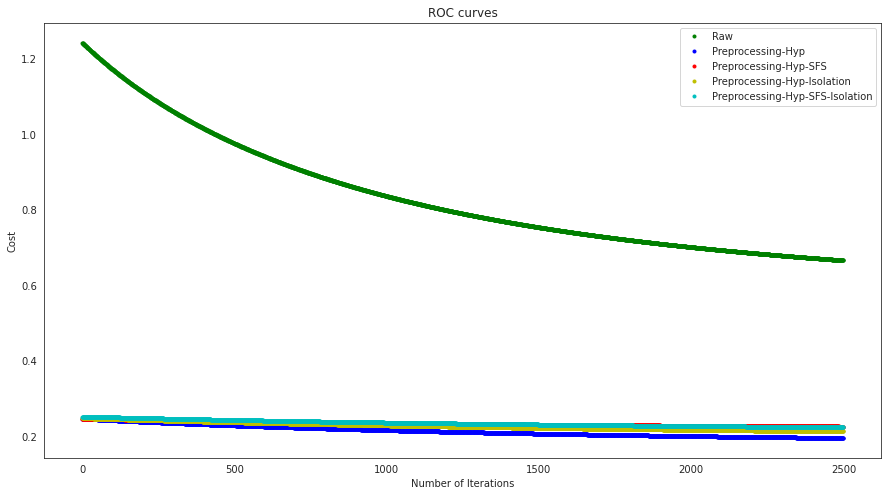

In [155]:


plt.figure(figsize=(15,8))
sns.set_style('white')

plt.plot(range(2500), cost_history_raw,'g.',label="Raw")
plt.plot(range(2500), cost_history_pre,'b.',label="Preprocessing-Hyp")
plt.plot(range(2500), cost_history_SFS,'r.',label="Preprocessing-Hyp-SFS")
plt.plot(range(2500), cost_history_pre_iso,'y.',label="Preprocessing-Hyp-Isolation")
plt.plot(range(2500), cost_history_SFS_iso,'c.',label="Preprocessing-Hyp-SFS-Isolation")


plt.title("ROC curves")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.legend(loc="upper right")


#plt.grid()
plt.show()

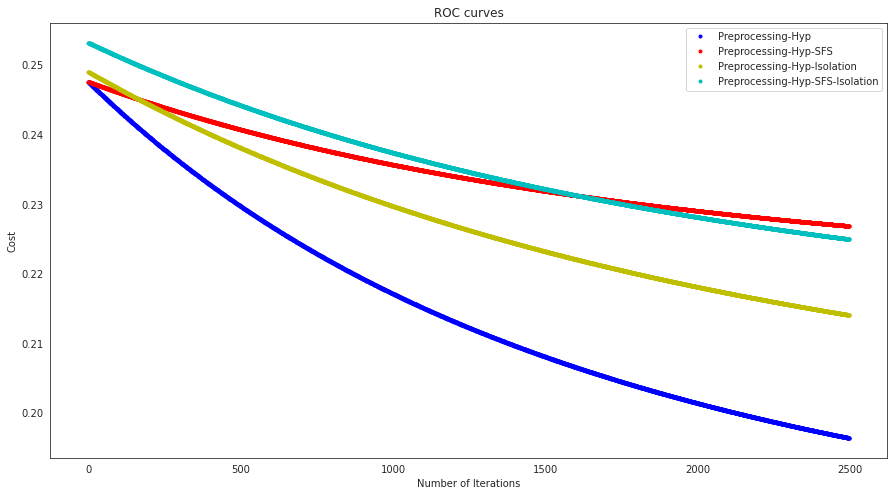

In [156]:
plt.figure(figsize=(15,8))
sns.set_style('white')

plt.plot(range(2500), cost_history_pre,'b.',label="Preprocessing-Hyp")
plt.plot(range(2500), cost_history_SFS,'r.',label="Preprocessing-Hyp-SFS")
plt.plot(range(2500), cost_history_pre_iso,'y.',label="Preprocessing-Hyp-Isolation")
plt.plot(range(2500), cost_history_SFS_iso,'c.',label="Preprocessing-Hyp-SFS-Isolation")


plt.title("ROC curves")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.legend(loc="upper right")


#plt.grid()
plt.show()